In [10]:
# !pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [11]:
# !kaggle datasets download -d gti-upm/leapgestrecog

100% 2.12G/2.13G [00:25<00:00, 115MB/s]
100% 2.13G/2.13G [00:25<00:00, 90.6MB/s]


In [ ]:
# ! unzip leapgestrecog.zip

#Dataset
Hand gesture recognition database is presented, composed by a set of near infrared images acquired by the Leap Motion sensor.
###Content:
This project uses the Hand Gesture Recognition Database (citation below) available on Kaggle. It contains 20000 images with different hands and hand gestures. There is a total of 10 hand gestures of 10 different people presented in the dataset. There are 5 female subjects and 5 male subjects. The images were captured using the Leap Motion hand tracking device.

The database is structured in different folders as:

*   /00 (subject with identifier 00)
    - /01_palm (images for palm gesture of subject 00)
        - 01palm/frame197957r.png,…,frame198136_l.png, … (images that corresponds to different samples obtained for the palm gesture performed by the subject with identifier 00)
    - /02_l (images for l gesture of subject 00)
    - /10_down

*   /01
*   /02
*   /09 (last subject with identifier 09)

Every root folder (00, 01,…) contains the infrared images of one subject. The folder name is the identifier of each different subject.

###*Citation*:
T. Mantecón, C.R. del Blanco, F. Jaureguizar, N. García, “Hand Gesture Recognition using Infrared Imagery Provided by Leap Motion Controller”, Int. Conf. on Advanced Concepts for Intelligent Vision Systems, ACIVS 2016, Lecce, Italy, pp. 47-57, 24-27 Oct. 2016. (doi: 10.1007/978-3-319-48680-2_5)

In [14]:
%matplotlib inline
from google.colab import files
import os

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

# Sklearn
from sklearn.model_selection import train_test_split 
from sklearn.metrics import confusion_matrix

print(tf.__version__)

2.7.0


###Overview:

* Load images
* Some validation
* Preparing the images for training
* Use of train_test_split

In [15]:
imagepaths = []

for root, dirs, files in os.walk("./", topdown=False):
  for name in files:
    path = os.path.join(root, name)
    if path.endswith("png"):
      imagepaths.append(path)
print(len(imagepaths))

20000


In [16]:
print(imagepaths[:5])

['./leapGestRecog/02/05_thumb/frame_02_05_0009.png', './leapGestRecog/02/05_thumb/frame_02_05_0177.png', './leapGestRecog/02/05_thumb/frame_02_05_0035.png', './leapGestRecog/02/05_thumb/frame_02_05_0031.png', './leapGestRecog/02/05_thumb/frame_02_05_0073.png']


In [17]:
def plot_image(path):
  img = cv2.imread(path)
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img_cvt.shape)
  plt.imshow(img_cvt)
  plt.xlabel("Width")
  plt.ylabel("Height")
  plt.title("Image" + path)

(240, 640)


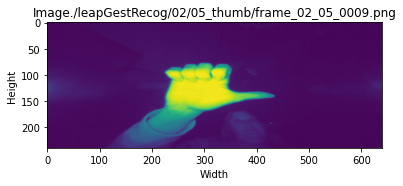

In [18]:
plot_image(imagepaths[0])

In [19]:
X = []
y = []

for path in imagepaths:
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  img = cv2.resize(img, (320,120))
  X.append(img)

  category = path.split("/")[3]
  label = int(category.split("_")[0][1])
  y.append(label)


In [20]:
# Turn X and y into np.array to speed up train_test_split
X = np.array(X, dtype="uint8")
X = X.reshape(len(imagepaths), 120, 320, 1) 
y = np.array(y)


In [21]:
print("Images loaded: ", len(X))
print("Labels loaded: ", len(y))

Images loaded:  20000
Labels loaded:  20000


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [23]:
print("X Train set {} --- y Train set: {}".format(X_train.shape,y_train.shape))
print("X Test set {} --- y Test set: {}".format(X_test.shape,y_test.shape))

X Train set (14000, 120, 320, 1) --- y Train set: (14000,)
X Test set (6000, 120, 320, 1) --- y Test set: (6000,)


###Overview:

* Import what the need
* Creation of CNN
* Compiling and training model
* Saving model for later use
* Plotting results

In [24]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Dense, Flatten

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 116, 316, 32)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 58, 158, 32)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 56, 156, 64)       18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 28, 78, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 76, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 38, 64)       0

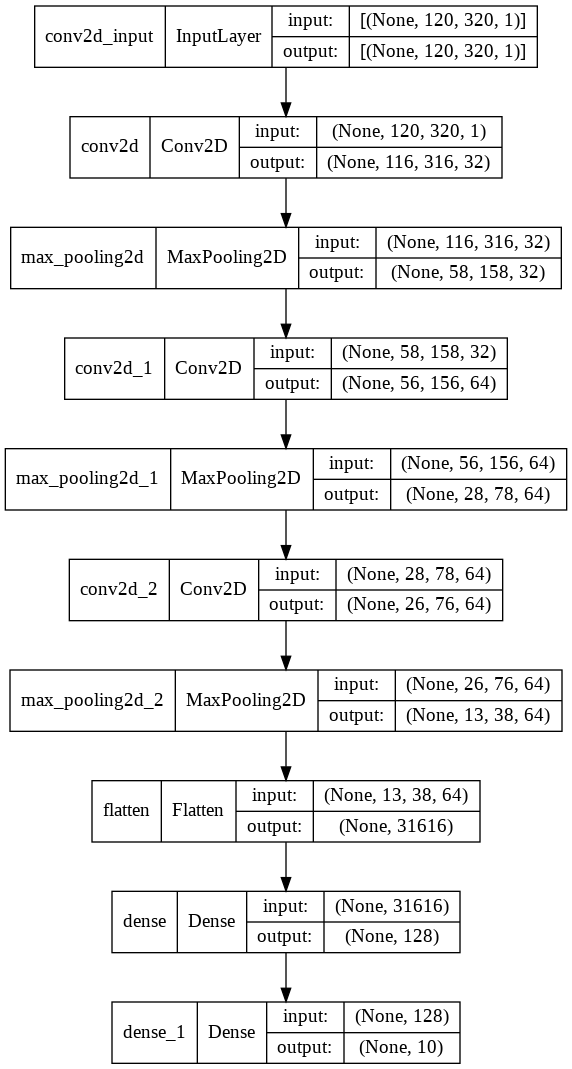

In [25]:
model = Sequential()
model.add(Conv2D(32, (5, 5), activation='relu', input_shape=(120, 320, 1))) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu')) 
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

In [26]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
model_history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/5
219/219 [==============================] - 40s 134ms/step - loss: 0.8238 - accuracy: 0.9270 - val_loss: 0.0398 - val_accuracy: 0.9900
Epoch 2/5
219/219 [==============================] - 29s 134ms/step - loss: 0.0041 - accuracy: 0.9988 - val_loss: 0.0067 - val_accuracy: 0.9978
Epoch 3/5
219/219 [==============================] - 28s 126ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0027 - val_accuracy: 0.9993
Epoch 4/5
219/219 [==============================] - 28s 126ms/step - loss: 9.7889e-04 - accuracy: 0.9997 - val_loss: 3.7398e-04 - val_accuracy: 1.0000
Epoch 5/5
219/219 [==============================] - 27s 125ms/step - loss: 0.0245 - accuracy: 0.9935 - val_loss: 0.0096 - val_accuracy: 0.9980


In [28]:
model.save('hand_reco_model.h5')

In [31]:
def show_training(history):
  import matplotlib.pyplot as plt
  history_dict = history.history
  #print(history_dict)
  loss_values = history_dict['loss']
  val_loss_values = history_dict['val_loss']
  #print(loss_values)
  #print(val_loss_values)
  epochs = range(1,len(loss_values)+1)
  plt.figure(figsize=(10,4))
  plt.yscale('log')
  plt.plot(epochs, loss_values, 'ro-', label='Traning loss')
  plt.plot(epochs, val_loss_values, 'bo-', label='Validation loss')
  plt.title('Traning and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

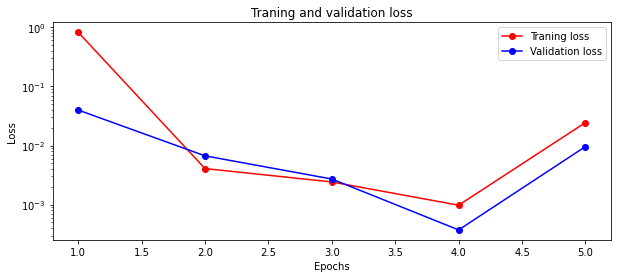

In [32]:
show_training(model_history)

###Overview:

* Evaluate model
* Predictions
* Plot images with predictions
* Confusion Matrix

In [33]:
test_loss, test_acc = model.evaluate(X_test, y_test)

print('Test accuracy: {:2.2f}%'.format(test_acc*100))

188/188 [==============================] - 6s 26ms/step - loss: 0.0096 - accuracy: 0.9980
Test accuracy: 99.80%


In [34]:
predictions = model.predict(X_test)

In [44]:
index = np.random.randint(0,len(predictions))
print("Sample: {}".format(index))
np.argmax(predictions[index]), y_test[index]

Sample: 4157


(7, 7)

In [61]:
#Plotting 3 by 3 images with their result (prediction, actual class)
def validate_9_images(predictions_array, true_label_array, img_array):
  class_names = ["down", "palm", "l", "fist", "fist_moved", "thumb", "index", "ok", "palm_moved", "c"] 
  plt.figure(figsize=(15,5))
  index = np.random.randint(0,len(predictions_array)-1) #select random images
  for i in range(1, 10):
    prediction = predictions_array[index+i]
    true_label = true_label_array[index+i]
    img = img_array[index+i]
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
    
    plt.subplot(3,3,i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(prediction) # Get index of the predicted label from prediction
    
    if predicted_label == true_label:
      color = 'blue'
    else:
      color = 'red'

    plt.xlabel("Predicted: {} {:2.0f}% (True: {})".format(class_names[predicted_label],
                                  100*np.max(prediction),
                                  class_names[true_label]),
                                  color=color)
  plt.show()

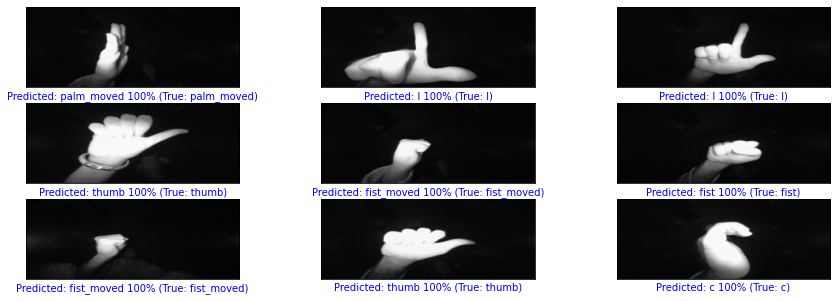

In [64]:
validate_9_images(predictions, y_test, X_test)

In [68]:
y_pred = np.argmax(predictions, axis=1)
pd.DataFrame(confusion_matrix(y_test, y_pred), 
             columns=["Predicted Thumb Down", "Predicted Palm (H)", "Predicted L", "Predicted Fist (H)", "Predicted Fist (V)", "Predicted Thumbs up", "Predicted Index", "Predicted OK", "Predicted Palm (V)", "Predicted C"],
             index=["Actual Thumb Down", "Actual Palm (H)", "Actual L", "Actual Fist (H)", "Actual Fist (V)", "Actual Thumbs up", "Actual Index", "Actual OK", "Actual Palm (V)", "Actual C"])


,Predicted Thumb Down,Predicted Palm (H),Predicted L,Predicted Fist (H),Predicted Fist (V),Predicted Thumbs up,Predicted Index,Predicted OK,Predicted Palm (V),Predicted C
Actual Thumb Down,567,0,0,0,1,0,0,0,0,0
Actual Palm (H),0,613,0,5,0,0,0,0,0,0
Actual L,0,0,590,0,0,1,0,0,0,0
Actual Fist (H),0,0,0,600,0,0,0,0,0,0
Actual Fist (V),0,0,0,0,621,0,0,0,0,0
Actual Thumbs up,0,0,0,1,0,604,0,0,0,0
Actual Index,0,0,0,3,0,0,608,0,0,0
Actual OK,0,0,0,0,0,0,0,596,0,0
Actual Palm (V),0,0,0,1,0,0,0,0,603,0
Actual C,0,0,0,0,0,0,0,0,0,586
